In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Loading MNIST

transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)

test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

In [3]:
train_data_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1000)

In [4]:
train_data_loader.batch_size

1000

In [5]:

# Building the encoder separately
class BasicBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BasicBlock, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.transform = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                       nn.Tanh(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.Tanh())
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_logsigma = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = self.transform(x)
        mu = self.fc_mu(out)
        logsigma = self.fc_logsigma(out)
        sigma = torch.exp(logsigma)
        return mu, sigma

In [6]:
# Removing data from train set
def removeProbData(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0],image.shape[1])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy(mask), torch.from_numpy(img_removed)

In [7]:
# Model
class MIWAE(nn.Module):
    def __init__(self, dim_h1, dim_image_vars):
        super(MIWAE, self).__init__()
        self.dim_h1 = dim_h1
        self.dim_image_vars = dim_image_vars

        ## encoder
        self.encoder_h1 = BasicBlock(dim_image_vars, 200, dim_h1)
        
        ## decoder
        self.decoder_x =  nn.Sequential(nn.Linear(dim_h1, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, 200),
                                        nn.Tanh(),
                                        nn.Linear(200, dim_image_vars),
                                        nn.Sigmoid())
        
    def encoder(self, x):
        mu_h1, sigma_h1 = self.encoder_h1(x)
        eps = Variable(sigma_h1.data.new(sigma_h1.size()).normal_())
        h1 = mu_h1 + sigma_h1 * eps   
        return h1, mu_h1, sigma_h1, eps
    
    def decoder(self, h1):
        p = self.decoder_x(h1)

        return p
    
    def forward(self, x):
        h1, mu_h1, sigma_h1, eps = self.encoder(x)
        p = self.decoder(h1)
        return (h1, mu_h1, sigma_h1, eps), (p)

    def train_loss(self, inputs):
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        loss_sigma = torch.sum(torch.log(sigma_h1), -1)
        loss_sigma_added = -torch.mean(torch.sum(loss_sigma, 0))
        print(loss_sigma_added)
        p = self.decoder(h1)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs*torch.log(p) + (1-inputs)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        weight = Variable(weight.data, requires_grad = False)
        loss = -torch.mean(torch.sum(weight * (log_Ph1 + log_PxGh1 - log_Qh1Gx), 0))+loss_sigma_added*loss_sigma_added
        print('loss=',loss)
        return loss

    
    def impute(self, inputs):
        inputs1 = inputs
        h1, mu_h1, sigma_h1, eps = self.encoder(inputs1)
        #log_Qh1Gx = torch.sum(-0.5*((h1-mu_h1)/sigma_h1)**2 - torch.log(sigma_h1), -1)
        log_Qh1Gx = torch.sum(-0.5*(eps)**2 - torch.log(sigma_h1), -1)
        
        p = self.decoder(h1)
        #print(p.shape)
        log_Ph1 = torch.sum(-0.5*h1**2, -1)
        log_PxGh1 = torch.sum(inputs1*torch.log(p) + (1-inputs1)*torch.log(1-p), -1)

        log_weight = log_Ph1 + log_PxGh1 - log_Qh1Gx
        log_weight = log_weight - torch.max(log_weight, 0)[0]
        
        weight = torch.exp(log_weight)
        weight = weight / torch.sum(weight, 0)
        #print(weight.shape)
        #weight = Variable(weight.data, requires_grad = False)
        weight.unsqueeze_(-1)
        weight = weight.expand(5,784)
        #print(weight.shape)
        img = torch.mean(weight * (p), 0)

        return img

In [8]:
# Define model with 50 sized hidden state
vae = MIWAE(50, 784)
vae.double()

MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
# Training on Incomplete Data
vae.double()
prob = 0.3
optimizer = optim.Adam(vae.parameters())
num_epoches = 50
train_loss_epoch = []
for epoch in range(num_epoches):
    running_loss = [] 
    for idx, data in enumerate(train_data_loader):
        inputs = Variable(data[0])
        print(type(inputs))
        
        inputs = inputs.view(-1, 28 * 28)
        mask, inputs = removeProbData(inputs, prob)
        inputs = inputs.expand(5, 1000, 784)
        
        optimizer.zero_grad()
        loss = vae.train_loss(inputs)
        loss.backward()
        optimizer.step()    
        print(("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}")
              .format(epoch, idx, loss.item()), flush = True)
        running_loss.append(loss.item())
    train_loss_epoch.append(np.mean(np.sum(running_loss)))

<class 'torch.Tensor'>
tensor(1.0404, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(544.5116, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:    0, loss: 544.51
<class 'torch.Tensor'>
tensor(-12.7229, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(699.7629, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:    1, loss: 699.76
<class 'torch.Tensor'>
tensor(-3.2443, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(541.4379, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:    2, loss: 541.44
<class 'torch.Tensor'>
tensor(3.4863, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(533.9798, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:    3, loss: 533.98
<class 'torch.Tensor'>
tensor(4.7499, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(532.5515, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:    4, loss: 532.55
<class 'torch.Tensor'>
tensor(1.9284,

Epoch:    0, Step:   42, loss: 178.26
<class 'torch.Tensor'>
tensor(0.1774, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.7697, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:   43, loss: 173.77
<class 'torch.Tensor'>
tensor(-0.3635, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(176.0632, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:   44, loss: 176.06
<class 'torch.Tensor'>
tensor(-0.5722, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(174.5267, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:   45, loss: 174.53
<class 'torch.Tensor'>
tensor(-0.5844, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(175.8232, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:   46, loss: 175.82
<class 'torch.Tensor'>
tensor(-0.4259, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(177.3735, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    0, Step:   47, loss: 177.3

Epoch:    1, Step:   25, loss: 174.30
<class 'torch.Tensor'>
tensor(-0.0858, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.7799, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    1, Step:   26, loss: 173.78
<class 'torch.Tensor'>
tensor(0.0407, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.6147, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    1, Step:   27, loss: 173.61
<class 'torch.Tensor'>
tensor(0.0430, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(177.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    1, Step:   28, loss: 177.08
<class 'torch.Tensor'>
tensor(0.1663, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.2056, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    1, Step:   29, loss: 171.21
<class 'torch.Tensor'>
tensor(0.1031, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.3645, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    1, Step:   30, loss: 173.36
<

Epoch:    2, Step:    8, loss: 174.46
<class 'torch.Tensor'>
tensor(-0.0236, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(176.2708, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:    9, loss: 176.27
<class 'torch.Tensor'>
tensor(0.0103, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(174.0909, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   10, loss: 174.09
<class 'torch.Tensor'>
tensor(0.0671, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(169.8325, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   11, loss: 169.83
<class 'torch.Tensor'>
tensor(-0.0133, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(174.3151, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   12, loss: 174.32
<class 'torch.Tensor'>
tensor(-0.0124, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.1663, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   13, loss: 173.17

Epoch:    2, Step:   51, loss: 171.24
<class 'torch.Tensor'>
tensor(-0.0150, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.4859, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   52, loss: 171.49
<class 'torch.Tensor'>
tensor(-0.0183, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(172.4637, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   53, loss: 172.46
<class 'torch.Tensor'>
tensor(0.0204, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.6533, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   54, loss: 171.65
<class 'torch.Tensor'>
tensor(-0.0043, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.6516, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   55, loss: 171.65
<class 'torch.Tensor'>
tensor(0.0044, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(172.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    2, Step:   56, loss: 172.77

Epoch:    3, Step:   34, loss: 171.78
<class 'torch.Tensor'>
tensor(-0.0156, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    3, Step:   35, loss: 171.99
<class 'torch.Tensor'>
tensor(0.0071, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.6452, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    3, Step:   36, loss: 171.65
<class 'torch.Tensor'>
tensor(-0.0005, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.2474, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    3, Step:   37, loss: 173.25
<class 'torch.Tensor'>
tensor(-0.0158, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(173.8922, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    3, Step:   38, loss: 173.89
<class 'torch.Tensor'>
tensor(0.0026, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(170.8244, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    3, Step:   39, loss: 170.82

Epoch:    4, Step:   17, loss: 169.22
<class 'torch.Tensor'>
tensor(0.0696, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(170.1427, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    4, Step:   18, loss: 170.14
<class 'torch.Tensor'>
tensor(0.0556, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(170.0623, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    4, Step:   19, loss: 170.06
<class 'torch.Tensor'>
tensor(0.0347, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(170.2749, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    4, Step:   20, loss: 170.27
<class 'torch.Tensor'>
tensor(-0.0397, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(170.4457, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    4, Step:   21, loss: 170.45
<class 'torch.Tensor'>
tensor(-0.0625, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(168.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    4, Step:   22, loss: 168.11


Epoch:    5, Step:    0, loss: 167.44
<class 'torch.Tensor'>
tensor(0.0288, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(166.0507, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:    1, loss: 166.05
<class 'torch.Tensor'>
tensor(0.0371, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(169.4438, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:    2, loss: 169.44
<class 'torch.Tensor'>
tensor(0.0300, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.7837, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:    3, loss: 165.78
<class 'torch.Tensor'>
tensor(-0.0346, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(171.2158, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:    4, loss: 171.22
<class 'torch.Tensor'>
tensor(0.0070, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(166.9551, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:    5, loss: 166.96
<

Epoch:    5, Step:   43, loss: 165.38
<class 'torch.Tensor'>
tensor(0.0015, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(168.2630, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:   44, loss: 168.26
<class 'torch.Tensor'>
tensor(-0.0080, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(166.1247, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:   45, loss: 166.12
<class 'torch.Tensor'>
tensor(-0.0256, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(167.7326, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:   46, loss: 167.73
<class 'torch.Tensor'>
tensor(0.0316, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(164.3807, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:   47, loss: 164.38
<class 'torch.Tensor'>
tensor(0.0667, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(166.6411, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    5, Step:   48, loss: 166.64


Epoch:    6, Step:   26, loss: 164.70
<class 'torch.Tensor'>
tensor(0.0685, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(164.4891, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    6, Step:   27, loss: 164.49
<class 'torch.Tensor'>
tensor(0.0495, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(168.4165, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    6, Step:   28, loss: 168.42
<class 'torch.Tensor'>
tensor(-0.0525, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.3464, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    6, Step:   29, loss: 165.35
<class 'torch.Tensor'>
tensor(-0.0214, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(167.0600, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    6, Step:   30, loss: 167.06
<class 'torch.Tensor'>
tensor(-0.0144, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(167.0694, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    6, Step:   31, loss: 167.07

Epoch:    7, Step:    9, loss: 166.53
<class 'torch.Tensor'>
tensor(-0.0566, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(164.1751, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   10, loss: 164.18
<class 'torch.Tensor'>
tensor(0.0138, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(163.9181, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   11, loss: 163.92
<class 'torch.Tensor'>
tensor(0.0271, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(164.4387, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   12, loss: 164.44
<class 'torch.Tensor'>
tensor(-0.0270, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.2491, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   13, loss: 165.25
<class 'torch.Tensor'>
tensor(-0.0173, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.6838, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   14, loss: 165.68

Epoch:    7, Step:   52, loss: 166.38
<class 'torch.Tensor'>
tensor(-0.0047, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.4675, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   53, loss: 165.47
<class 'torch.Tensor'>
tensor(0.0685, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(163.6887, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   54, loss: 163.69
<class 'torch.Tensor'>
tensor(0.0569, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(164.7408, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   55, loss: 164.74
<class 'torch.Tensor'>
tensor(0.0176, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(165.5174, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   56, loss: 165.52
<class 'torch.Tensor'>
tensor(-0.0685, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(162.4284, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    7, Step:   57, loss: 162.43


Epoch:    8, Step:   35, loss: 161.79
<class 'torch.Tensor'>
tensor(0.0758, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(162.1468, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    8, Step:   36, loss: 162.15
<class 'torch.Tensor'>
tensor(0.0263, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(163.0044, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    8, Step:   37, loss: 163.00
<class 'torch.Tensor'>
tensor(-0.0041, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(161.2844, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    8, Step:   38, loss: 161.28
<class 'torch.Tensor'>
tensor(-0.0820, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(162.4546, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    8, Step:   39, loss: 162.45
<class 'torch.Tensor'>
tensor(0.0215, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(162.7610, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    8, Step:   40, loss: 162.76


Epoch:    9, Step:   18, loss: 161.69
<class 'torch.Tensor'>
tensor(0.0229, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(160.1236, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    9, Step:   19, loss: 160.12
<class 'torch.Tensor'>
tensor(0.0466, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(157.2756, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    9, Step:   20, loss: 157.28
<class 'torch.Tensor'>
tensor(-0.0360, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(162.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    9, Step:   21, loss: 162.09
<class 'torch.Tensor'>
tensor(0.0185, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(159.4014, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    9, Step:   22, loss: 159.40
<class 'torch.Tensor'>
tensor(0.0511, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(161.8486, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:    9, Step:   23, loss: 161.85
<

Epoch:   10, Step:    1, loss: 158.31
<class 'torch.Tensor'>
tensor(0.0374, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(159.0851, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:    2, loss: 159.09
<class 'torch.Tensor'>
tensor(0.0526, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(158.2360, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:    3, loss: 158.24
<class 'torch.Tensor'>
tensor(-0.0948, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(157.7812, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:    4, loss: 157.78
<class 'torch.Tensor'>
tensor(0.0208, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(156.3767, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:    5, loss: 156.38
<class 'torch.Tensor'>
tensor(0.0861, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(158.3120, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:    6, loss: 158.31
<

Epoch:   10, Step:   44, loss: 155.67
<class 'torch.Tensor'>
tensor(0.0203, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(155.6272, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:   45, loss: 155.63
<class 'torch.Tensor'>
tensor(0.0782, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(154.0966, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:   46, loss: 154.10
<class 'torch.Tensor'>
tensor(0.0499, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(157.9407, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:   47, loss: 157.94
<class 'torch.Tensor'>
tensor(-0.0862, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(155.7074, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:   48, loss: 155.71
<class 'torch.Tensor'>
tensor(-0.0616, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(153.1521, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   10, Step:   49, loss: 153.15


Epoch:   11, Step:   27, loss: 151.38
<class 'torch.Tensor'>
tensor(-0.2040, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(148.8302, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   11, Step:   28, loss: 148.83
<class 'torch.Tensor'>
tensor(-0.0296, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(150.1130, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   11, Step:   29, loss: 150.11
<class 'torch.Tensor'>
tensor(0.1936, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(150.5035, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   11, Step:   30, loss: 150.50
<class 'torch.Tensor'>
tensor(-0.0391, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(149.1359, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   11, Step:   31, loss: 149.14
<class 'torch.Tensor'>
tensor(-0.0556, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(150.2436, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   11, Step:   32, loss: 150.2

Epoch:   12, Step:   10, loss: 147.19
<class 'torch.Tensor'>
tensor(-0.0565, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(150.1846, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   11, loss: 150.18
<class 'torch.Tensor'>
tensor(0.0821, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(149.5836, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   12, loss: 149.58
<class 'torch.Tensor'>
tensor(0.0153, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(148.9248, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   13, loss: 148.92
<class 'torch.Tensor'>
tensor(-0.0680, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(148.3886, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   14, loss: 148.39
<class 'torch.Tensor'>
tensor(0.1017, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(149.8508, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   15, loss: 149.85


Epoch:   12, Step:   53, loss: 146.39
<class 'torch.Tensor'>
tensor(0.2647, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(143.2772, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   54, loss: 143.28
<class 'torch.Tensor'>
tensor(-0.1575, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(145.9005, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   55, loss: 145.90
<class 'torch.Tensor'>
tensor(0.0277, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(145.7843, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   56, loss: 145.78
<class 'torch.Tensor'>
tensor(0.2189, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(142.5013, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   57, loss: 142.50
<class 'torch.Tensor'>
tensor(-0.3775, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(145.1813, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   12, Step:   58, loss: 145.18


Epoch:   13, Step:   36, loss: 143.86
<class 'torch.Tensor'>
tensor(0.0647, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.4126, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   13, Step:   37, loss: 141.41
<class 'torch.Tensor'>
tensor(0.2242, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(144.6772, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   13, Step:   38, loss: 144.68
<class 'torch.Tensor'>
tensor(-0.3272, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(146.6524, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   13, Step:   39, loss: 146.65
<class 'torch.Tensor'>
tensor(0.2867, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(145.4325, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   13, Step:   40, loss: 145.43
<class 'torch.Tensor'>
tensor(-0.0588, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(143.4718, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   13, Step:   41, loss: 143.47


Epoch:   14, Step:   19, loss: 145.44
<class 'torch.Tensor'>
tensor(0.0451, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(144.4775, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   14, Step:   20, loss: 144.48
<class 'torch.Tensor'>
tensor(-0.0468, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(144.5651, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   14, Step:   21, loss: 144.57
<class 'torch.Tensor'>
tensor(0.1135, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(145.6703, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   14, Step:   22, loss: 145.67
<class 'torch.Tensor'>
tensor(-0.1292, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.4279, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   14, Step:   23, loss: 141.43
<class 'torch.Tensor'>
tensor(0.2264, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(142.7893, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   14, Step:   24, loss: 142.79


Epoch:   15, Step:    2, loss: 140.57
<class 'torch.Tensor'>
tensor(-0.3873, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:    3, loss: 141.60
<class 'torch.Tensor'>
tensor(0.4491, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(142.7657, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:    4, loss: 142.77
<class 'torch.Tensor'>
tensor(-0.2246, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.4527, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:    5, loss: 141.45
<class 'torch.Tensor'>
tensor(-0.0831, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.8240, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:    6, loss: 141.82
<class 'torch.Tensor'>
tensor(0.4372, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(142.3839, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:    7, loss: 142.38

Epoch:   15, Step:   45, loss: 140.81
<class 'torch.Tensor'>
tensor(-0.6711, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(140.2269, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:   46, loss: 140.23
<class 'torch.Tensor'>
tensor(0.5708, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(139.4452, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:   47, loss: 139.45
<class 'torch.Tensor'>
tensor(-0.1318, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(142.0956, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:   48, loss: 142.10
<class 'torch.Tensor'>
tensor(-0.3329, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(141.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:   49, loss: 141.03
<class 'torch.Tensor'>
tensor(0.7186, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(140.1993, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   15, Step:   50, loss: 140.20

Epoch:   16, Step:   28, loss: 139.53
<class 'torch.Tensor'>
tensor(-0.5062, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(137.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   16, Step:   29, loss: 137.86
<class 'torch.Tensor'>
tensor(0.0230, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(137.7415, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   16, Step:   30, loss: 137.74
<class 'torch.Tensor'>
tensor(0.6570, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(140.5341, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   16, Step:   31, loss: 140.53
<class 'torch.Tensor'>
tensor(-0.9824, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(140.8627, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   16, Step:   32, loss: 140.86
<class 'torch.Tensor'>
tensor(0.7661, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(139.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   16, Step:   33, loss: 139.52


Epoch:   17, Step:   11, loss: 139.34
<class 'torch.Tensor'>
tensor(0.0887, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(137.5585, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   12, loss: 137.56
<class 'torch.Tensor'>
tensor(-0.6362, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.9710, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   13, loss: 136.97
<class 'torch.Tensor'>
tensor(0.7384, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(137.6858, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   14, loss: 137.69
<class 'torch.Tensor'>
tensor(-0.2793, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(137.1092, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   15, loss: 137.11
<class 'torch.Tensor'>
tensor(-0.2271, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(138.7882, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   16, loss: 138.79

Epoch:   17, Step:   54, loss: 138.24
<class 'torch.Tensor'>
tensor(-0.1150, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(138.4228, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   55, loss: 138.42
<class 'torch.Tensor'>
tensor(0.4466, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(138.1176, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   56, loss: 138.12
<class 'torch.Tensor'>
tensor(-0.4475, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(139.8734, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   57, loss: 139.87
<class 'torch.Tensor'>
tensor(0.1816, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.6514, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   58, loss: 135.65
<class 'torch.Tensor'>
tensor(0.3078, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(139.8091, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   17, Step:   59, loss: 139.81


Epoch:   18, Step:   37, loss: 136.01
<class 'torch.Tensor'>
tensor(0.4403, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.6968, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   18, Step:   38, loss: 136.70
<class 'torch.Tensor'>
tensor(-0.6345, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(138.1374, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   18, Step:   39, loss: 138.14
<class 'torch.Tensor'>
tensor(0.6839, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.8953, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   18, Step:   40, loss: 136.90
<class 'torch.Tensor'>
tensor(-0.5084, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(138.3965, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   18, Step:   41, loss: 138.40
<class 'torch.Tensor'>
tensor(0.2605, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.8999, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   18, Step:   42, loss: 134.90


Epoch:   19, Step:   20, loss: 133.90
<class 'torch.Tensor'>
tensor(0.0491, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.1219, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   19, Step:   21, loss: 134.12
<class 'torch.Tensor'>
tensor(0.3595, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.4606, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   19, Step:   22, loss: 135.46
<class 'torch.Tensor'>
tensor(-0.4104, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.4872, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   19, Step:   23, loss: 136.49
<class 'torch.Tensor'>
tensor(0.1818, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.8293, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   19, Step:   24, loss: 136.83
<class 'torch.Tensor'>
tensor(0.3041, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.1697, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   19, Step:   25, loss: 135.17
<

Epoch:   20, Step:    3, loss: 136.13
<class 'torch.Tensor'>
tensor(-0.0040, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.9815, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:    4, loss: 135.98
<class 'torch.Tensor'>
tensor(-0.1808, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.9164, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:    5, loss: 132.92
<class 'torch.Tensor'>
tensor(0.2968, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.5979, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:    6, loss: 135.60
<class 'torch.Tensor'>
tensor(-0.2043, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.4459, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:    7, loss: 133.45
<class 'torch.Tensor'>
tensor(0.1299, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.4611, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:    8, loss: 133.46

Epoch:   20, Step:   46, loss: 135.89
<class 'torch.Tensor'>
tensor(-0.3822, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.3294, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:   47, loss: 136.33
<class 'torch.Tensor'>
tensor(0.4682, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.1392, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:   48, loss: 135.14
<class 'torch.Tensor'>
tensor(-0.2905, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.9221, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:   49, loss: 134.92
<class 'torch.Tensor'>
tensor(0.0647, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.8057, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:   50, loss: 136.81
<class 'torch.Tensor'>
tensor(0.1653, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.5690, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   20, Step:   51, loss: 133.57


Epoch:   21, Step:   29, loss: 134.40
<class 'torch.Tensor'>
tensor(-0.0798, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.3037, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   21, Step:   30, loss: 134.30
<class 'torch.Tensor'>
tensor(-0.0513, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.0586, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   21, Step:   31, loss: 135.06
<class 'torch.Tensor'>
tensor(0.2791, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.4320, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   21, Step:   32, loss: 134.43
<class 'torch.Tensor'>
tensor(-0.2806, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.5673, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   21, Step:   33, loss: 136.57
<class 'torch.Tensor'>
tensor(0.1303, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(136.8862, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   21, Step:   34, loss: 136.89

Epoch:   22, Step:   12, loss: 132.93
<class 'torch.Tensor'>
tensor(-0.2036, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.1548, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   13, loss: 134.15
<class 'torch.Tensor'>
tensor(0.1224, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.3237, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   14, loss: 135.32
<class 'torch.Tensor'>
tensor(0.0149, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.0382, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   15, loss: 132.04
<class 'torch.Tensor'>
tensor(-0.0017, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(135.7122, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   16, loss: 135.71
<class 'torch.Tensor'>
tensor(-0.0503, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.8808, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   17, loss: 133.88

Epoch:   22, Step:   55, loss: 132.41
<class 'torch.Tensor'>
tensor(0.0316, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.4712, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   56, loss: 133.47
<class 'torch.Tensor'>
tensor(-0.1642, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.0321, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   57, loss: 133.03
<class 'torch.Tensor'>
tensor(0.1386, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.4281, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   58, loss: 134.43
<class 'torch.Tensor'>
tensor(0.0080, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.9433, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   22, Step:   59, loss: 131.94
<class 'torch.Tensor'>
tensor(0.0503, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(134.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:    0, loss: 134.49
<

Epoch:   23, Step:   38, loss: 132.25
<class 'torch.Tensor'>
tensor(0.0621, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.2406, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:   39, loss: 133.24
<class 'torch.Tensor'>
tensor(0.2411, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.8967, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:   40, loss: 132.90
<class 'torch.Tensor'>
tensor(-0.2794, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.3105, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:   41, loss: 132.31
<class 'torch.Tensor'>
tensor(0.1723, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.2215, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:   42, loss: 133.22
<class 'torch.Tensor'>
tensor(0.1349, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.9788, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   23, Step:   43, loss: 133.98
<

Epoch:   24, Step:   21, loss: 131.23
<class 'torch.Tensor'>
tensor(0.0292, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.3950, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   24, Step:   22, loss: 133.39
<class 'torch.Tensor'>
tensor(0.0452, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.4224, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   24, Step:   23, loss: 133.42
<class 'torch.Tensor'>
tensor(-0.0493, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.0347, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   24, Step:   24, loss: 131.03
<class 'torch.Tensor'>
tensor(0.0894, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.3998, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   24, Step:   25, loss: 132.40
<class 'torch.Tensor'>
tensor(0.0187, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   24, Step:   26, loss: 131.02
<

Epoch:   25, Step:    4, loss: 132.00
<class 'torch.Tensor'>
tensor(-0.4417, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.5212, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:    5, loss: 132.52
<class 'torch.Tensor'>
tensor(0.5849, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.1697, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:    6, loss: 133.17
<class 'torch.Tensor'>
tensor(-0.1894, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.7125, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:    7, loss: 132.71
<class 'torch.Tensor'>
tensor(-0.2510, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.5612, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:    8, loss: 133.56
<class 'torch.Tensor'>
tensor(0.5229, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.0362, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:    9, loss: 131.04

Epoch:   25, Step:   47, loss: 132.89
<class 'torch.Tensor'>
tensor(-0.3258, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.1662, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:   48, loss: 129.17
<class 'torch.Tensor'>
tensor(0.3460, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.4043, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:   49, loss: 133.40
<class 'torch.Tensor'>
tensor(-0.0197, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.4286, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:   50, loss: 132.43
<class 'torch.Tensor'>
tensor(-0.2933, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.5536, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:   51, loss: 132.55
<class 'torch.Tensor'>
tensor(0.5183, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.7187, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   25, Step:   52, loss: 132.72

Epoch:   26, Step:   30, loss: 133.27
<class 'torch.Tensor'>
tensor(-0.1689, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.6724, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   26, Step:   31, loss: 130.67
<class 'torch.Tensor'>
tensor(0.0018, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.6661, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   26, Step:   32, loss: 133.67
<class 'torch.Tensor'>
tensor(0.2298, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(133.5580, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   26, Step:   33, loss: 133.56
<class 'torch.Tensor'>
tensor(-0.0882, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.4748, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   26, Step:   34, loss: 130.47
<class 'torch.Tensor'>
tensor(-0.1258, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.6832, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   26, Step:   35, loss: 130.68

Epoch:   27, Step:   13, loss: 129.94
<class 'torch.Tensor'>
tensor(0.3516, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.6822, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   14, loss: 131.68
<class 'torch.Tensor'>
tensor(-0.2705, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.9818, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   15, loss: 131.98
<class 'torch.Tensor'>
tensor(0.0615, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   16, loss: 132.41
<class 'torch.Tensor'>
tensor(0.2709, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.0356, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   17, loss: 132.04
<class 'torch.Tensor'>
tensor(-0.2740, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.3256, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   18, loss: 132.33


Epoch:   27, Step:   56, loss: 130.94
<class 'torch.Tensor'>
tensor(-0.2643, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.6336, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   57, loss: 129.63
<class 'torch.Tensor'>
tensor(0.0586, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.0637, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   58, loss: 130.06
<class 'torch.Tensor'>
tensor(0.1305, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(132.2571, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   27, Step:   59, loss: 132.26
<class 'torch.Tensor'>
tensor(-0.1144, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.6523, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:    0, loss: 128.65
<class 'torch.Tensor'>
tensor(0.0759, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.1381, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:    1, loss: 130.14


Epoch:   28, Step:   39, loss: 129.20
<class 'torch.Tensor'>
tensor(-0.6296, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.6290, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:   40, loss: 130.63
<class 'torch.Tensor'>
tensor(0.4755, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.2776, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:   41, loss: 131.28
<class 'torch.Tensor'>
tensor(0.3435, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.9975, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:   42, loss: 131.00
<class 'torch.Tensor'>
tensor(-0.5732, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.4308, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:   43, loss: 131.43
<class 'torch.Tensor'>
tensor(0.0619, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.6176, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   28, Step:   44, loss: 129.62


Epoch:   29, Step:   22, loss: 128.78
<class 'torch.Tensor'>
tensor(0.5698, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.8299, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   29, Step:   23, loss: 131.83
<class 'torch.Tensor'>
tensor(-0.1005, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.4997, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   29, Step:   24, loss: 131.50
<class 'torch.Tensor'>
tensor(-0.4424, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.9448, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   29, Step:   25, loss: 130.94
<class 'torch.Tensor'>
tensor(0.3735, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.8683, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   29, Step:   26, loss: 127.87
<class 'torch.Tensor'>
tensor(0.2917, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.5097, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   29, Step:   27, loss: 128.51


Epoch:   30, Step:    5, loss: 130.41
<class 'torch.Tensor'>
tensor(-0.9321, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.4385, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:    6, loss: 129.44
<class 'torch.Tensor'>
tensor(0.5462, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.8434, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:    7, loss: 130.84
<class 'torch.Tensor'>
tensor(0.6635, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.1624, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:    8, loss: 131.16
<class 'torch.Tensor'>
tensor(-0.7452, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.4603, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:    9, loss: 129.46
<class 'torch.Tensor'>
tensor(-0.2585, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.7144, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   10, loss: 129.71

Epoch:   30, Step:   48, loss: 129.49
<class 'torch.Tensor'>
tensor(0.1379, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.7156, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   49, loss: 128.72
<class 'torch.Tensor'>
tensor(-0.1039, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.3151, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   50, loss: 130.32
<class 'torch.Tensor'>
tensor(-0.0253, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.9122, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   51, loss: 131.91
<class 'torch.Tensor'>
tensor(0.1521, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.2793, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   52, loss: 131.28
<class 'torch.Tensor'>
tensor(0.0033, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.3803, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   30, Step:   53, loss: 129.38


Epoch:   31, Step:   31, loss: 131.13
<class 'torch.Tensor'>
tensor(-0.2322, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.4978, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   31, Step:   32, loss: 128.50
<class 'torch.Tensor'>
tensor(0.1574, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   31, Step:   33, loss: 130.20
<class 'torch.Tensor'>
tensor(0.0441, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.9211, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   31, Step:   34, loss: 129.92
<class 'torch.Tensor'>
tensor(-0.1167, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.4525, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   31, Step:   35, loss: 129.45
<class 'torch.Tensor'>
tensor(0.2143, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.8543, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   31, Step:   36, loss: 128.85


Epoch:   32, Step:   14, loss: 128.72
<class 'torch.Tensor'>
tensor(-0.2178, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.2056, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   15, loss: 129.21
<class 'torch.Tensor'>
tensor(-0.1397, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.7284, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   16, loss: 129.73
<class 'torch.Tensor'>
tensor(0.3791, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.8672, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   17, loss: 130.87
<class 'torch.Tensor'>
tensor(-0.2259, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   18, loss: 130.41
<class 'torch.Tensor'>
tensor(0.0104, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.3521, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   19, loss: 129.35

Epoch:   32, Step:   57, loss: 129.64
<class 'torch.Tensor'>
tensor(0.0294, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.6548, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   58, loss: 127.65
<class 'torch.Tensor'>
tensor(0.3549, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.3908, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   32, Step:   59, loss: 128.39
<class 'torch.Tensor'>
tensor(-0.3691, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.6257, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:    0, loss: 128.63
<class 'torch.Tensor'>
tensor(0.1337, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3426, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:    1, loss: 127.34
<class 'torch.Tensor'>
tensor(0.3373, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.1540, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:    2, loss: 130.15
<

Epoch:   33, Step:   40, loss: 129.50
<class 'torch.Tensor'>
tensor(0.0583, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.1653, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:   41, loss: 128.17
<class 'torch.Tensor'>
tensor(-0.1933, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.2144, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:   42, loss: 128.21
<class 'torch.Tensor'>
tensor(0.3094, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.1665, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:   43, loss: 128.17
<class 'torch.Tensor'>
tensor(-0.0531, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.9427, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:   44, loss: 128.94
<class 'torch.Tensor'>
tensor(-0.2084, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.9013, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   33, Step:   45, loss: 129.90

Epoch:   34, Step:   23, loss: 128.90
<class 'torch.Tensor'>
tensor(-0.1947, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.5985, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   34, Step:   24, loss: 128.60
<class 'torch.Tensor'>
tensor(-0.2209, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.7065, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   34, Step:   25, loss: 127.71
<class 'torch.Tensor'>
tensor(0.5221, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.7001, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   34, Step:   26, loss: 128.70
<class 'torch.Tensor'>
tensor(-0.1955, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.4610, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   34, Step:   27, loss: 128.46
<class 'torch.Tensor'>
tensor(-0.2395, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.6141, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   34, Step:   28, loss: 129.6

Epoch:   35, Step:    6, loss: 128.12
<class 'torch.Tensor'>
tensor(-0.1847, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.7824, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:    7, loss: 127.78
<class 'torch.Tensor'>
tensor(0.1083, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.1206, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:    8, loss: 128.12
<class 'torch.Tensor'>
tensor(0.2120, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(131.5626, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:    9, loss: 131.56
<class 'torch.Tensor'>
tensor(-0.3079, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.1788, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   10, loss: 129.18
<class 'torch.Tensor'>
tensor(0.1501, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.1622, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   11, loss: 129.16


Epoch:   35, Step:   49, loss: 129.45
<class 'torch.Tensor'>
tensor(-0.0198, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.8615, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   50, loss: 127.86
<class 'torch.Tensor'>
tensor(-0.0446, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.8407, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   51, loss: 127.84
<class 'torch.Tensor'>
tensor(0.2358, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.4683, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   52, loss: 128.47
<class 'torch.Tensor'>
tensor(0.0198, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.3102, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   53, loss: 130.31
<class 'torch.Tensor'>
tensor(-0.3250, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.6342, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   35, Step:   54, loss: 130.63

Epoch:   36, Step:   32, loss: 128.48
<class 'torch.Tensor'>
tensor(-0.2292, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.5682, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   36, Step:   33, loss: 128.57
<class 'torch.Tensor'>
tensor(-0.3612, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.9359, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   36, Step:   34, loss: 127.94
<class 'torch.Tensor'>
tensor(0.6215, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.9201, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   36, Step:   35, loss: 127.92
<class 'torch.Tensor'>
tensor(-0.0568, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.5784, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   36, Step:   36, loss: 128.58
<class 'torch.Tensor'>
tensor(-0.4557, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.2619, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   36, Step:   37, loss: 126.2

Epoch:   37, Step:   15, loss: 127.48
<class 'torch.Tensor'>
tensor(0.5659, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(130.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   16, loss: 130.16
<class 'torch.Tensor'>
tensor(-0.3447, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.4423, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   17, loss: 129.44
<class 'torch.Tensor'>
tensor(-0.1158, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.5547, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   18, loss: 129.55
<class 'torch.Tensor'>
tensor(0.3542, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.2644, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   19, loss: 129.26
<class 'torch.Tensor'>
tensor(0.0577, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.5531, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   20, loss: 128.55


Epoch:   37, Step:   58, loss: 128.92
<class 'torch.Tensor'>
tensor(0.0345, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.2610, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   37, Step:   59, loss: 128.26
<class 'torch.Tensor'>
tensor(0.1467, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.1051, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:    0, loss: 129.11
<class 'torch.Tensor'>
tensor(-0.1589, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.6734, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:    1, loss: 128.67
<class 'torch.Tensor'>
tensor(0.1815, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.2336, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:    2, loss: 129.23
<class 'torch.Tensor'>
tensor(-0.0839, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.8433, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:    3, loss: 125.84


Epoch:   38, Step:   41, loss: 126.00
<class 'torch.Tensor'>
tensor(0.1711, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.8303, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:   42, loss: 126.83
<class 'torch.Tensor'>
tensor(-0.1358, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.6882, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:   43, loss: 129.69
<class 'torch.Tensor'>
tensor(-0.1755, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3761, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:   44, loss: 127.38
<class 'torch.Tensor'>
tensor(0.3772, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.0927, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:   45, loss: 127.09
<class 'torch.Tensor'>
tensor(-0.0865, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.3003, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   38, Step:   46, loss: 128.30

Epoch:   39, Step:   24, loss: 126.25
<class 'torch.Tensor'>
tensor(-0.1040, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.2513, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   39, Step:   25, loss: 128.25
<class 'torch.Tensor'>
tensor(-0.2526, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.0336, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   39, Step:   26, loss: 128.03
<class 'torch.Tensor'>
tensor(0.2955, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3122, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   39, Step:   27, loss: 127.31
<class 'torch.Tensor'>
tensor(0.0761, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.1434, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   39, Step:   28, loss: 127.14
<class 'torch.Tensor'>
tensor(-0.1326, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3914, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   39, Step:   29, loss: 127.39

Epoch:   40, Step:    7, loss: 127.57
<class 'torch.Tensor'>
tensor(-0.0079, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.6608, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:    8, loss: 126.66
<class 'torch.Tensor'>
tensor(-0.0288, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.2901, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:    9, loss: 129.29
<class 'torch.Tensor'>
tensor(-0.0134, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.9944, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   10, loss: 125.99
<class 'torch.Tensor'>
tensor(0.2373, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.2953, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   11, loss: 128.30
<class 'torch.Tensor'>
tensor(-0.1711, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.6823, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   12, loss: 128.6

Epoch:   40, Step:   50, loss: 126.80
<class 'torch.Tensor'>
tensor(-0.1795, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.8764, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   51, loss: 127.88
<class 'torch.Tensor'>
tensor(0.0546, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.3765, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   52, loss: 124.38
<class 'torch.Tensor'>
tensor(0.2680, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.6331, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   53, loss: 126.63
<class 'torch.Tensor'>
tensor(-0.1005, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.0873, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   54, loss: 127.09
<class 'torch.Tensor'>
tensor(-0.0942, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.3776, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   40, Step:   55, loss: 126.38

Epoch:   41, Step:   33, loss: 126.50
<class 'torch.Tensor'>
tensor(0.2524, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.8610, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   41, Step:   34, loss: 125.86
<class 'torch.Tensor'>
tensor(0.1872, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.8477, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   41, Step:   35, loss: 127.85
<class 'torch.Tensor'>
tensor(-0.4211, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   41, Step:   36, loss: 127.28
<class 'torch.Tensor'>
tensor(0.2856, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.8083, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   41, Step:   37, loss: 129.81
<class 'torch.Tensor'>
tensor(0.0938, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.5503, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   41, Step:   38, loss: 127.55
<

Epoch:   42, Step:   16, loss: 126.49
<class 'torch.Tensor'>
tensor(-0.1516, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.1338, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   42, Step:   17, loss: 126.13
<class 'torch.Tensor'>
tensor(0.5183, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.2619, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   42, Step:   18, loss: 127.26
<class 'torch.Tensor'>
tensor(-0.1745, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.4047, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   42, Step:   19, loss: 127.40
<class 'torch.Tensor'>
tensor(-0.3188, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.2432, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   42, Step:   20, loss: 129.24
<class 'torch.Tensor'>
tensor(0.3511, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.4415, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   42, Step:   21, loss: 127.44

Epoch:   42, Step:   59, loss: 126.44
<class 'torch.Tensor'>
tensor(0.3736, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.2900, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:    0, loss: 126.29
<class 'torch.Tensor'>
tensor(0.2904, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.9558, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:    1, loss: 127.96
<class 'torch.Tensor'>
tensor(-0.6293, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.9479, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:    2, loss: 126.95
<class 'torch.Tensor'>
tensor(0.2496, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.9774, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:    3, loss: 125.98
<class 'torch.Tensor'>
tensor(0.6594, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(129.4177, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:    4, loss: 129.42
<

Epoch:   43, Step:   42, loss: 129.12
<class 'torch.Tensor'>
tensor(-0.2788, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.6135, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:   43, loss: 127.61
<class 'torch.Tensor'>
tensor(-0.0539, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.3709, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:   44, loss: 125.37
<class 'torch.Tensor'>
tensor(0.4158, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.6919, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:   45, loss: 128.69
<class 'torch.Tensor'>
tensor(-0.2227, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.0697, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:   46, loss: 126.07
<class 'torch.Tensor'>
tensor(-0.1525, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.8873, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   43, Step:   47, loss: 125.8

Epoch:   44, Step:   25, loss: 125.94
<class 'torch.Tensor'>
tensor(0.1324, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   44, Step:   26, loss: 126.04
<class 'torch.Tensor'>
tensor(-0.2629, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.4697, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   44, Step:   27, loss: 125.47
<class 'torch.Tensor'>
tensor(0.1621, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.9879, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   44, Step:   28, loss: 124.99
<class 'torch.Tensor'>
tensor(0.1910, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.9804, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   44, Step:   29, loss: 124.98
<class 'torch.Tensor'>
tensor(-0.1547, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(123.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   44, Step:   30, loss: 123.59


Epoch:   45, Step:    8, loss: 127.39
<class 'torch.Tensor'>
tensor(-0.2995, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:    9, loss: 127.31
<class 'torch.Tensor'>
tensor(0.3766, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.4798, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   10, loss: 127.48
<class 'torch.Tensor'>
tensor(0.0577, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.1301, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   11, loss: 126.13
<class 'torch.Tensor'>
tensor(-0.1683, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.9660, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   12, loss: 126.97
<class 'torch.Tensor'>
tensor(0.0318, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(128.1464, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   13, loss: 128.15


Epoch:   45, Step:   51, loss: 126.30
<class 'torch.Tensor'>
tensor(-0.0928, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.0476, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   52, loss: 126.05
<class 'torch.Tensor'>
tensor(0.2533, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.4414, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   53, loss: 126.44
<class 'torch.Tensor'>
tensor(-0.1549, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.2134, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   54, loss: 127.21
<class 'torch.Tensor'>
tensor(0.1327, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.9223, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   55, loss: 125.92
<class 'torch.Tensor'>
tensor(0.1713, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.8187, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   45, Step:   56, loss: 126.82


Epoch:   46, Step:   34, loss: 126.44
<class 'torch.Tensor'>
tensor(0.4282, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.7212, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   46, Step:   35, loss: 127.72
<class 'torch.Tensor'>
tensor(-0.3621, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.5706, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   46, Step:   36, loss: 125.57
<class 'torch.Tensor'>
tensor(0.0650, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.5515, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   46, Step:   37, loss: 126.55
<class 'torch.Tensor'>
tensor(0.3747, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.5402, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   46, Step:   38, loss: 126.54
<class 'torch.Tensor'>
tensor(-0.2577, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.1669, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   46, Step:   39, loss: 126.17


Epoch:   47, Step:   17, loss: 124.76
<class 'torch.Tensor'>
tensor(0.1520, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.8591, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   47, Step:   18, loss: 126.86
<class 'torch.Tensor'>
tensor(0.0226, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.9287, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   47, Step:   19, loss: 126.93
<class 'torch.Tensor'>
tensor(-0.1316, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.6419, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   47, Step:   20, loss: 126.64
<class 'torch.Tensor'>
tensor(0.1201, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.3506, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   47, Step:   21, loss: 127.35
<class 'torch.Tensor'>
tensor(-0.0603, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.1787, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   47, Step:   22, loss: 125.18


Epoch:   48, Step:    0, loss: 127.13
<class 'torch.Tensor'>
tensor(0.1933, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.7810, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:    1, loss: 124.78
<class 'torch.Tensor'>
tensor(0.3916, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.0989, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:    2, loss: 126.10
<class 'torch.Tensor'>
tensor(-0.3745, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.3629, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:    3, loss: 126.36
<class 'torch.Tensor'>
tensor(0.1862, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.4367, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:    4, loss: 127.44
<class 'torch.Tensor'>
tensor(-0.1235, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.3129, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:    5, loss: 126.31


Epoch:   48, Step:   43, loss: 126.09
<class 'torch.Tensor'>
tensor(0.4758, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.7536, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:   44, loss: 126.75
<class 'torch.Tensor'>
tensor(0.1418, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.8303, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:   45, loss: 124.83
<class 'torch.Tensor'>
tensor(-0.3338, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.2744, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:   46, loss: 125.27
<class 'torch.Tensor'>
tensor(-0.0867, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.3294, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:   47, loss: 125.33
<class 'torch.Tensor'>
tensor(0.4922, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(127.2502, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   48, Step:   48, loss: 127.25


Epoch:   49, Step:   26, loss: 124.93
<class 'torch.Tensor'>
tensor(0.4413, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.3799, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   49, Step:   27, loss: 125.38
<class 'torch.Tensor'>
tensor(-0.0863, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(125.5821, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   49, Step:   28, loss: 125.58
<class 'torch.Tensor'>
tensor(-0.2708, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(126.7659, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   49, Step:   29, loss: 126.77
<class 'torch.Tensor'>
tensor(0.1525, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.7796, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   49, Step:   30, loss: 124.78
<class 'torch.Tensor'>
tensor(0.2823, dtype=torch.float64, grad_fn=<NegBackward>)
loss= ggg tensor(124.6178, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch:   49, Step:   31, loss: 124.62


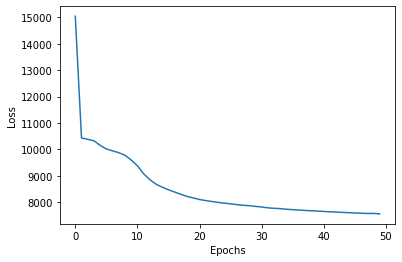

In [10]:
plt.plot(train_loss_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [11]:
PATH = "miwae_with_changes.pt"
torch.save(vae.state_dict(), PATH)


In [12]:
vae.load_state_dict(torch.load("miwae_with_changes.pt"))
vae.eval()

MIWAE(
  (encoder_h1): BasicBlock(
    (transform): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): Tanh()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Tanh()
    )
    (fc_mu): Linear(in_features=200, out_features=50, bias=True)
    (fc_logsigma): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder_x): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [13]:
# Reading some of the test data
for epoch in range(1):
    running_loss = [] 
    for idx, data in enumerate(test_data_loader):
        inputs = Variable(data[0])
        inputs = inputs.view(-1, 28 * 28)
        inputs = inputs.expand(5, 1000, 784)

In [14]:
# Removing Pixels while testing
def removeProbDataTest(tensorOG, p):
    image =tensorOG.numpy()
    nump = np.random.rand(image.shape[0])
    mask = (nump<(1-p))*1.0
    img_removed = mask*image
    
    return torch.from_numpy((mask==0)*1), torch.from_numpy(img_removed)

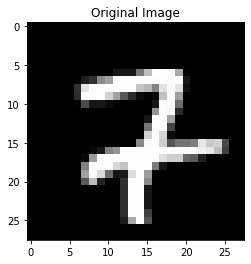

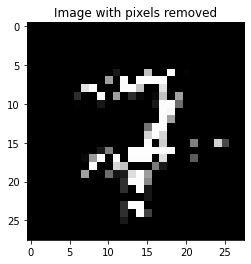

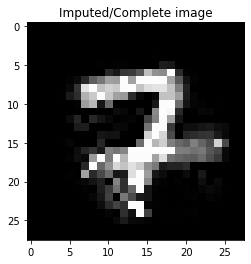

In [18]:
# Choose an image number
number_chosen = 44

image_og = (inputs[0][number_chosen])
img_og = image_og.view(28, 28).data
plt.figure()
plt.imshow(img_og, cmap='gray')
plt.title('Original Image')
plt.show()

mask, image_og_removed = removeProbDataTest(inputs[0][number_chosen],0.5)
image_og_removed = image_og_removed.view(28, 28).data
mask= mask.view(28, 28).data

plt.figure()
plt.title('Image with pixels removed')
plt.imshow(image_og_removed, cmap='gray')
plt.show()

vae.float()
image_imputed = vae.impute(inputs[0][number_chosen])
image_imputed = image_imputed.view(28, 28).data
image_final = image_imputed*mask + image_og_removed
plt.figure()
plt.title('Imputed/Complete image')
plt.imshow(image_final,cmap='gray')
plt.show()

